In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')



In [2]:
df = pd.read_csv('/home/mikepi/Coding/Excs/time_series_rob_mulla/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'PJME_East_Power_Cons_MWT'}, xlabel='Datetime'>

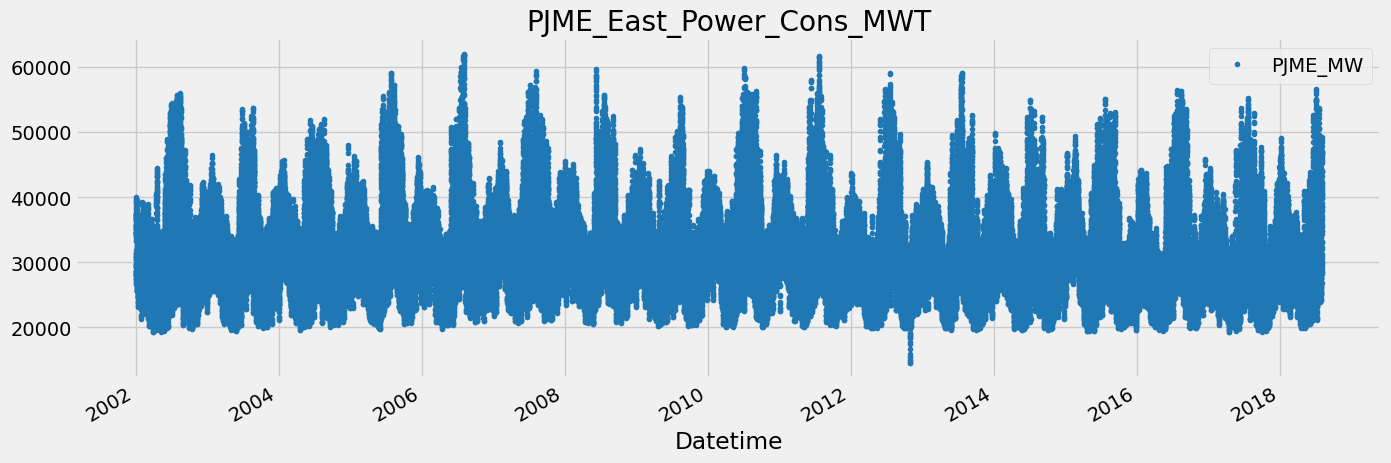

In [3]:
df.plot(style='.', 
        figsize=(15, 5), 
        color=color_pal[0], 
        title='PJME_East_Power_Cons_MWT')

Train / Test Split

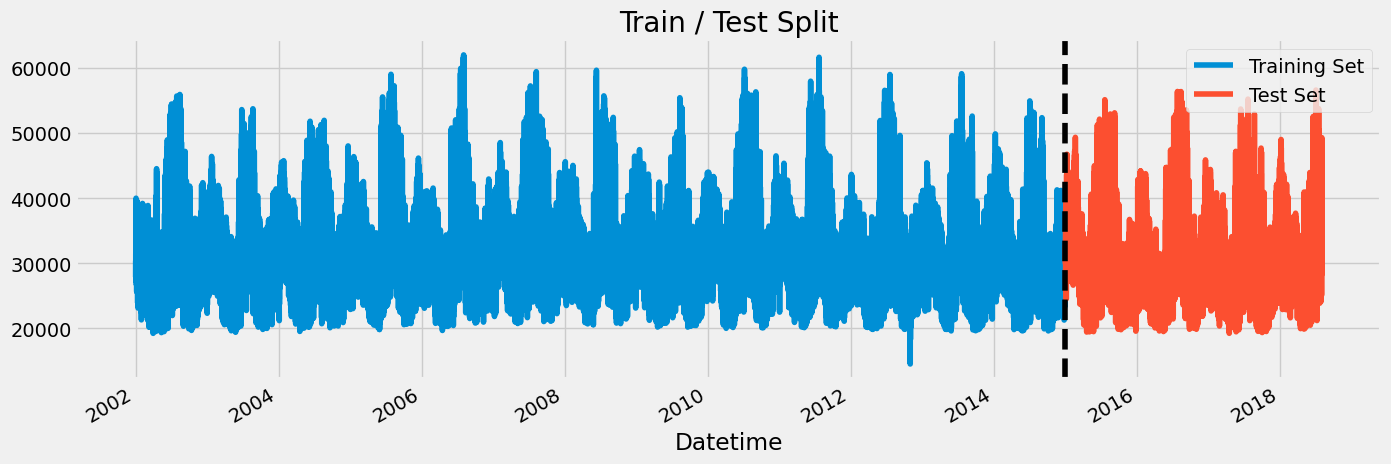

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train / Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls ='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: xlabel='Datetime'>

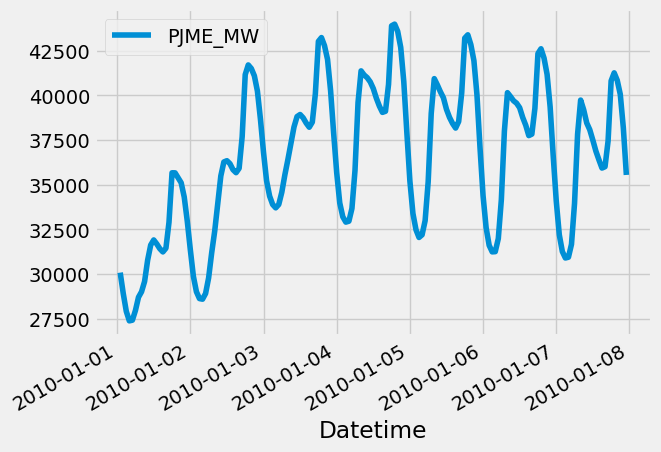

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()

# Feature Creation

In [6]:
def create_features(df):
    '''
    Creat time series features based on time series index.
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

Vizualize our Feature / Target Relationship 

/tmp/ipykernel_44554/994714248.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Reds')


Text(0.5, 1.0, 'MW by Hour')

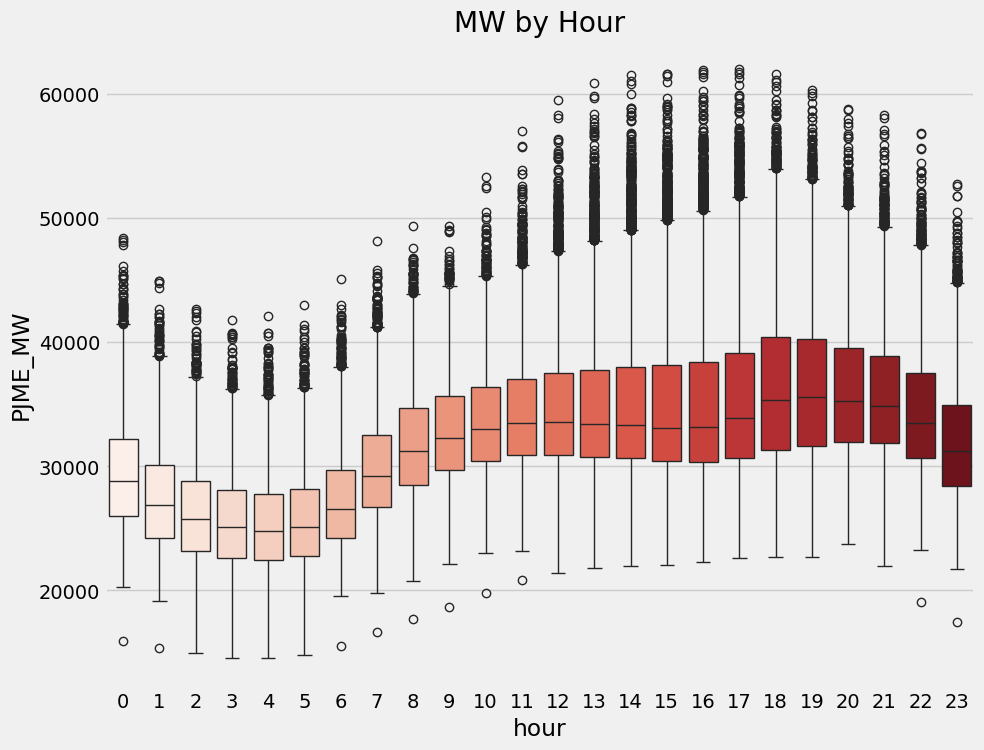

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Reds')
ax.set_title('MW by Hour')

/tmp/ipykernel_44554/3269659845.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


Text(0.5, 1.0, 'MW by Month')

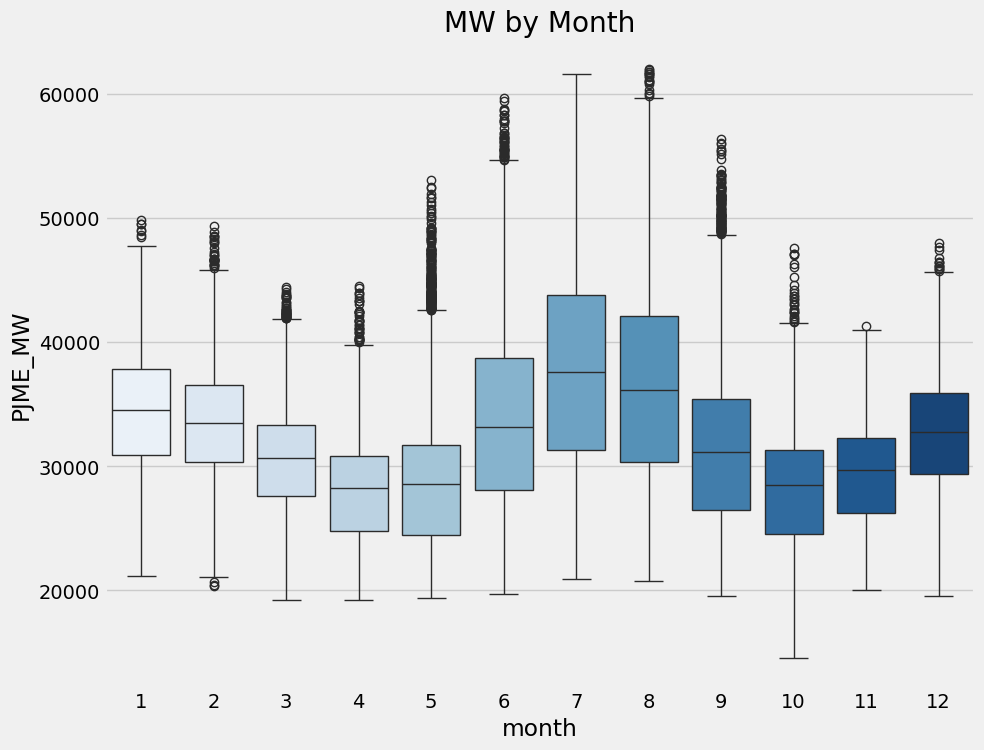

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')

Create our Model

In [9]:
train = create_features(train)
test = create_features(test)

In [10]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [11]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'PJME_MW'

In [12]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature Importance

In [14]:
reg.feature_importances_

array([    0.46388,       0.162,    0.028881,     0.20316,    0.023824,     0.11825], dtype=float32)

In [15]:
fi = pd.DataFrame(data=reg.feature_importances_, 
                  index=reg.feature_names_in_,
                  columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

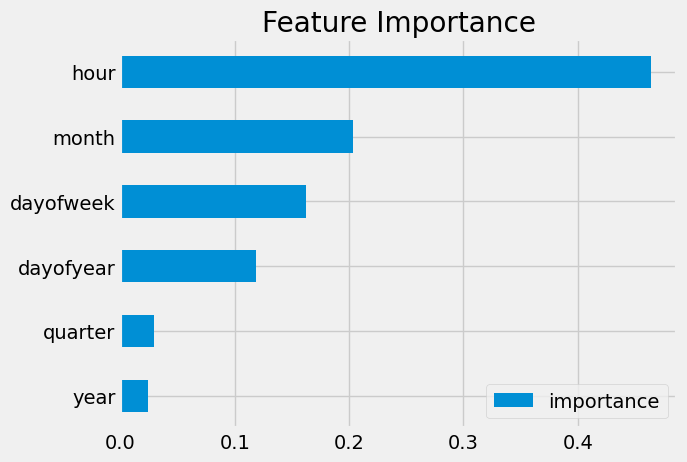

In [16]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

Forecast on Test

In [17]:
test['prediction'] = reg.predict(X_test)

In [18]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [19]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,41545.953125
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41135.625000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39968.492188


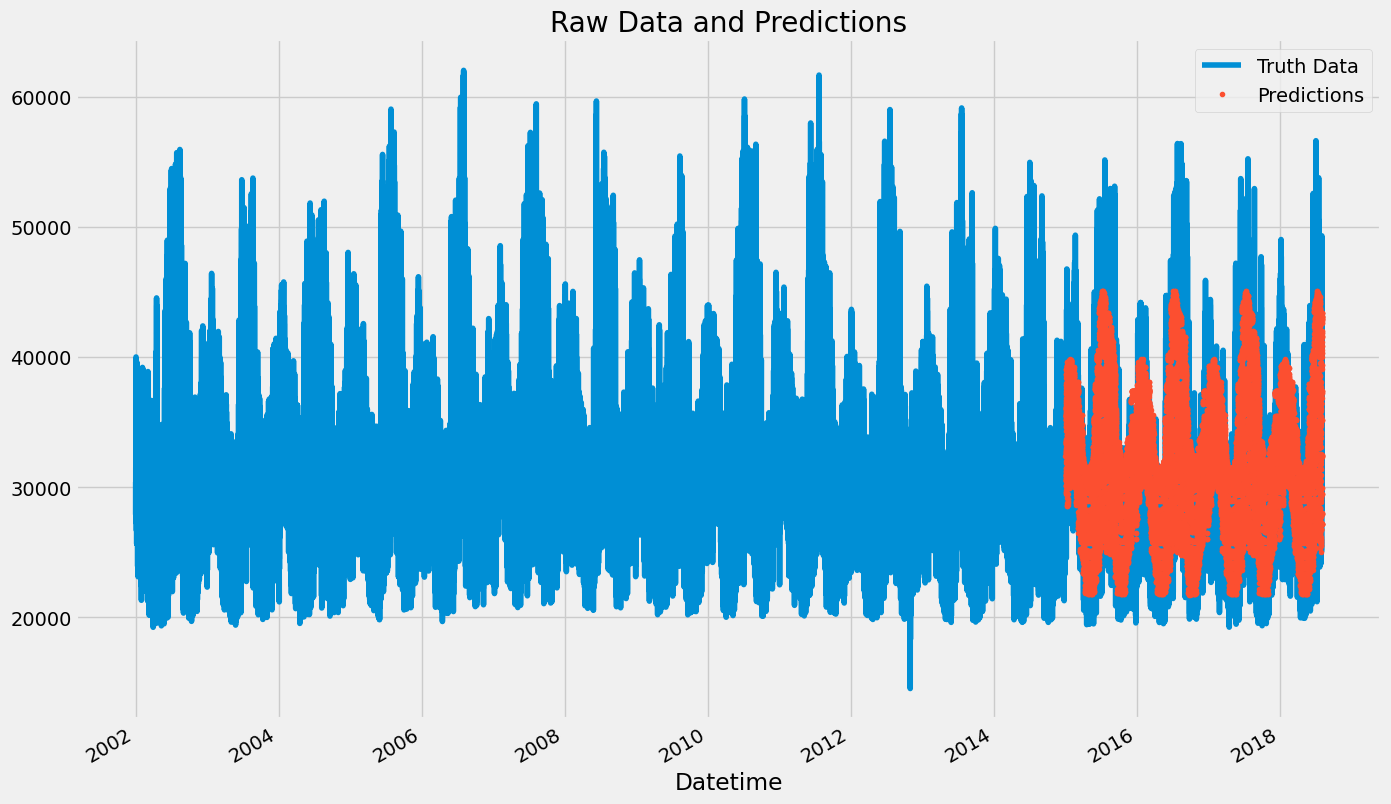

In [20]:
ax = df[['PJME_MW']].plot(figsize=(15, 10))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

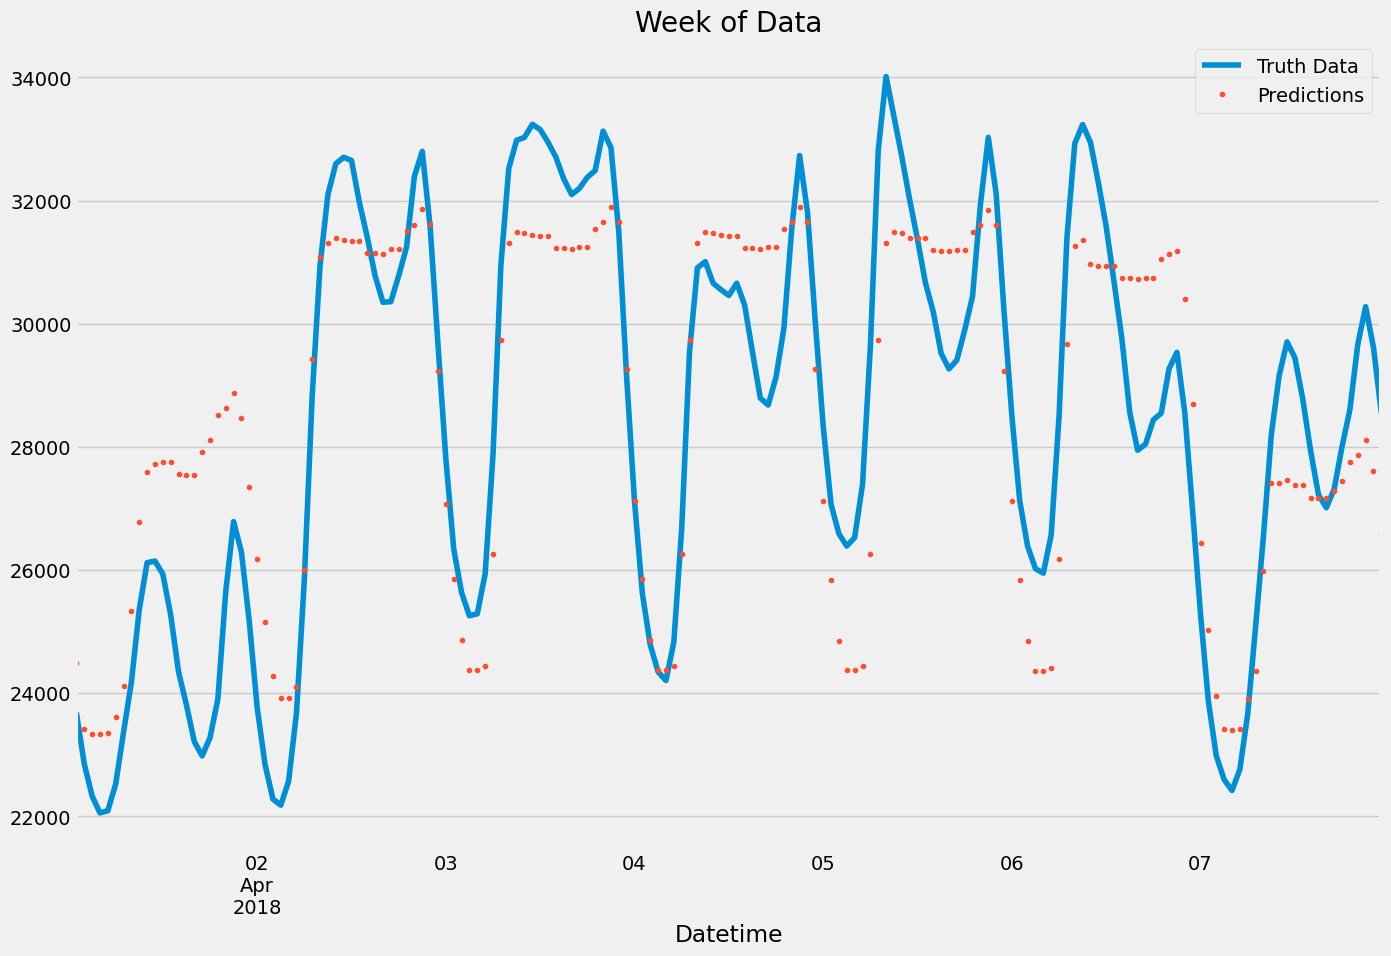

In [21]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
             .plot(figsize=(15, 10), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Data and Predictions')
plt.show()




In [22]:
round(np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction'])), 2)

3741.03

Calculate Error

In [23]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [24]:
test['date'] = test.index.date

In [25]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

Next:
- more robust cross validation
- add more features (weather forecast, holidays etc)